# <p style="text-align: center;"> Charter school identities and outcomes in the accountability era:<br/> Preliminary results
<p style="text-align: center;">April 19th, 2017<br/>By Jaren Haber, PhD Candidate<break/>Dept. of Sociology, UC Berkeley

<p style="text-align: center;">![alt text](http://jaypgreene.files.wordpress.com/2009/12/explosion_600x625600x625.jpg "Old U.S. Map of charter schools by state")
<p style="text-align: center;">(this out-dated graphic courtesy of U.S. News & World Report, 2009)

## Research questions
**How are charter schools different from each other in terms of ideology? How do these differences shape their survival and their outcomes, and what does this reveal about current educational policy?** 

## The corpus
- Website self-descriptions of all **6,753 charter schools** open in 2014-15 (identified using the NCES Public School Universe Survey)
- Charter school websites are a publicly visible proclamation of identity attempting to impress parents, regulators, etc.
- This study the first to use this contemporary, comprehensive data source on U.S. charter school identities
- Me & research team working on using BeautifulSoup and requests.get to webscrape the full sample

### Motivation
- Too much focus on test scores in education, too little on organizational aspects
- Are charter schools innovative? How?
- How does educational policy shape ed. philosophy? Organization? Outcomes?
- No one has studied charters' public image as expressed in their OWN words

### Methods
- NLP: Word frequencies, distinctive words, etc.
- Supervised: Custom dictionaries
- Unsupervised: Topic models, word embeddings
- Later: statistical regression to test, e.g., how progressivist schools in liberal communities have higher performance than they do in other places

## Preliminary analysis: website self-descriptions of non-random sample of 196 schools
- Early-stage sample: NOT representative!
- About half randomly selected, half tracked down (many through Internet Archive) because of missing URLs
- Closed schools over-represented

## Preliminary conclusions: 
### Word counts:
- Website self-descriptions for schools in mid-sized cities and suburbs tend to be longest, followed by other urban and suburban schools, then schools in towns, and shortest tends to be rural schools
- Charter schools in cities and suburbs have the highest textual redundancy (lowest ratio of types to tokens)

### Word embeddings:
- The two educational philosophies I'm interested in--**progressivism** and **essentialism**--can be distinguished using semantic vectors
- Useful way for creating and checking my dictionaries

### Topic modeling:
- Urban charter schools' websites emphasize **GOALS** (topic 0)
- Suburban charter schools' websites emphasize **CURRICULUM** (topic 1) in addition to goals

## Next steps:
- Working with custom dictionaries, POS tagging
- Webscraping and parsing HTML to get full sample
- Match website text with data on test scores and community characteristics (e.g., race, class, political leanings) --> test hypotheses with statistical regression<br/><br/>
- **More long-term**: Collect longitudinal mission statement data from the Internet Archive --> look at survival and geographic dispersion of identity categories over time (especially pre-NCLB if possible)

In [1]:
# The keyword categories to help parse website text:
mission = ['mission',' vision ', 'vision:', 'mission:', 'our purpose', 'our ideals', 'ideals:', 'our cause', 'cause:', 'goals', 'objective']
curriculum = ['curriculum', 'curricular', 'program', 'method', 'pedagogy', 'pedagogical', 'approach', 'model', 'system', 'structure']
philosophy = ['philosophy', 'philosophical', 'beliefs', 'believe', 'principles', 'creed', 'credo', 'value',  'moral']
history = ['history', 'our story', 'the story', 'school story', 'background', 'founding', 'founded', 'established', 'establishment', 'our school began', 'we began', 'doors opened', 'school opened']
general =  ['about us', 'our school', 'who we are', 'overview', 'general information', 'our identity', 'profile', 'highlights']

## Initializing Python

In [2]:
#!/usr/bin/env python
# -*- coding: UTF-8

In [3]:
# IMPORTING KEY PACKAGES
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas # for working with dataframes
import numpy as np # for working with numbers

In [4]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # an approximate method of stemming words (it just cuts off the ends)
from nltk.corpus import stopwords # for one method of eliminating stop words, to clean the text
stopenglish = list(stopwords.words("english")) # assign the string of english stopwords to a variable and turn it into a list
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign the string of common punctuation symbols to a variable and turn it into a list

In [5]:
# FOR ANALYZING WITH THE TEXT
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

import gensim # for word embedding models
from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

In [6]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Reading in preliminary data

In [61]:
sample = [] # make empty list
with open('micro-sample_2013.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        sample.append(row) # append each row to the list

# Also read in output.csv, to get newly parsed webtext
new_output = [] # make empty list
with open('output.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        new_output.append(row) # append each row to the list

In [62]:
sample[0]

OrderedDict([('LEANM', 'RICHLAND 02'),
             ('SEARCH',
              'RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, COLUMBIA, SC'),
             ('CER_NAME', 'Richland Two Charter High School'),
             ('URL', 'https://www.richland2.org/charterhigh/'),
             ('ADDRESS', '750 OLD CLEMSON RD, COLUMBIA, SC'),
             ('SCHOOL ID', 'SC600'),
             ('LEVEL', '3'),
             ('YEAR_OPEN_CER', '2010'),
             ('CER_MS_2012',
              'Flexible schedule allows students to work and explore different careers while receiving their high school diploma.'),
             ('SURVYEAR', '2013'),
             ('NCESSCH', '4.50E+11'),
             ('FIPST', '45'),
             ('LEAID', '4503390'),
             ('SCHNO', '1554'),
             ('STID', '4002'),
             ('SEASCH', '600'),
             ('SCHNAM', 'RICHLAND TWO CHARTER HIGH'),
             ('PHONE', '8034191348'),
             ('MSTREE', '750 OLD CLEMSON ROAD'),
             ('MCITY', 'COLUM

In [63]:
new_output[0]

OrderedDict([('SEARCH',
              'Richland Two Charter High 750 Old Clemson Road, Columbia, SC 29229'),
             ('MANUAL_URL', 'https://www.richland2.org/charterhigh/'),
             ('OLD_URL', 'https://www.richland2.org/charterhigh'),
             ('ADDRESS', '750 Old Clemson Road, Columbia, SC 29229'),
             ('STABR', 'SC'),
             ('NCESSCH', '450339001554'),
             ('SCH_NAME', 'Richland Two Charter High'),
             ('folder_name', '001 Richland Two Charter High'),
             ('parsed_files',
              "['/Users/bradafzali/research/text_analysis/wget_sept8/001 Richland Two Charter High/www.richland2.org/charterhigh/index.html']"),
             ('alltext',
              '\n\n\n2016 Richland Two Career Pathways Expo Richland School District Two will be hosting a Career Pathways Expo on Thursday, October 27 from 3:00 pm to 7:00 pm at the newest facility, R2i2 (behind the Village at Sandhill). All students in grades 7-12 along with their parents/

In [65]:
# First initialize every school's WEBTEXT value
for s in sample:
    s["WEBTEXT"] = ""

# For every school in which we have parsed html, use string matching to find
# the matching school in micro-sample_2013.csv
for output in new_output:
    index = 0
    for s in sample:
        if s["SCHNAM"].lower() == output["SCH_NAME"].lower():
            break
        index += 1
    # If index is 300, then the school name from output.csv was not found in micro-sample_2013.csv
    if index != 300:
        sample[index]["WEBTEXT"] = output["alltext"]

# Write 
with open('merged.csv', 'w', newline='') as csvfile:
    fieldnames = list(sample[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for s in sample:
        writer.writerow(s)

In [66]:
# Take a look at the most important contents and the variables list
# in our sample (a list of dictionaries)--let's look at just the first entry
print(sample[1]["SCHNAM"], "\n", sample[1]["URL"], "\n", sample[1]["WEBTEXT"], "\n")
print(sample[1].keys()) # look at all the variables!

POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 
 https://www.polk.edu/lakeland-gateway-to-college-high-school/ 
 


Back to Polk.edu Search the Polk State network Financial Aid Guaranteed Processing Deadline is December 1, 2016 Tuesday, 11/01/16 - Thursday, 12/01/16 Polk State College Thanksgiving Break (College Closed â No Saturday Classes on 11/26/16) Wednesday, 11/23/16 - Sunday, 11/27/16 Last Faculty Work Day Wednesday, 12/14/16 - All Day Graduation Wednesday, 12/14/16 | 6:30 PM - 8:00 PM The Lakeland Center, 701 Lime St, Lakeland Polk State Lakeland Gateway to College High School is governed by the Polk State College District Board of Trustees . The Meeting Minutes for the 2013-14 year are available HERE . The Meeting Minutes for the 2014-15 year are available HERE . The Meeting Minutes for the 2015-16 year are available HERE . 6.29.16 Polkâs Top Grads: Gateway Salutatorian Found Academic Footing and âGained Confidenceâ 6.23.16 Polkâs Top Grads: Gateway Valedictorian âHas t

In [67]:
# Read the data in as a pandas dataframe
df = pandas.read_csv("merged.csv", encoding = 'Latin-1')
df = df.dropna(subset=["WEBTEXT"]) # drop any schools with no webtext that might have snuck in (none currently)

In [68]:
# Add additional variables for analysis:
# PCTETH = percentage of enrolled students belonging to a racial minority
# this includes American Indian, Asian, Hispanic, Black, Hawaiian, or Pacific Islander
df["PCTETH"] = (df["AM"] + df["ASIAN"] + df["HISP"] + df["BLACK"] + df["PACIFIC"]) / df["MEMBER"]

df["STR"] = df["MEMBER"] / df["FTE"] # Student/teacher ratio
df["PCTFRPL"] = df["TOTFRL"] / df["MEMBER"] # Percent of students receiving FRPL

# Another interesting variable: 
# TYPE = type of school, where 1 = regular, 2 = special ed, 3 = vocational, 4 = other/alternative, 5 = reportable program

In [69]:
## Print the webtext from the first school in the dataframe
print(df.iloc[0]["WEBTEXT"])




2016 Richland Two Career Pathways Expo Richland School District Two will be hosting a Career Pathways Expo on Thursday, October 27 from 3:00 pm to 7:00 pm at the newest facility, R2i2 (behind the Village at Sandhill). All students in grades 7-12 along with their parents/and or guardians are invited to attend . Students will be able to explore careers and educational opportunities in 5 career areas--Health Science, Art, STEM, Business/IT, Human Services/Education. You will have the opportunity to speak with businesses and educational institutions to see the connection of what you are learning in high school to a possible career. If you have any questions, please contact Mrs. Holland. The Richland 2 Charter High School has moved to a new location! We are now located at: The Anna Boyd School 7900 Brookmont Lane Columbia, SC 29203 Congratulations to our 2016 Graduates!! click here to view a video of the ceremony Click here to view thevideo of the June 4, 2015 graduation ceremony. Richla

## Descriptive statistics

### How urban proximity is coded: Lower number = more urban (closer to large city) 

More specifically, it uses two digits with distinct meanings: 
- the first digit: 
    - 1 = city
    - 2 = suburb
    - 3 = town
    - 4 = rural
- the second digit:
    - 1 = large or fringe
    - 2 = mid-size or distant
    - 3 = small/remote

In [70]:
print(df.describe()) # get descriptive statistics for all numerical columns
print()
print(df['ULOCAL'].value_counts()) # frequency counts for categorical data
print()
print(df['LEVEL'].value_counts()) # treat grade range served as categorical
# Codes for level/ grade range served: 3 = High school, 2 = Middle school, 1 = Elementary, 4 = Other)
print()
print(df['LSTATE'].mode()) # find the most common state represented in these data
print(df['ULOCAL'].mode()) # find the most urbanicity represented in these data
# print(df['FTE']).mean() # What's the average number of full-time employees by school?
# print(df['STR']).mean() # And the average student-teacher ratio?

       YEAR_OPEN_CER  SURVYEAR       NCESSCH       FIPST         LEAID  \
count     194.000000     233.0  2.330000e+02  233.000000  2.330000e+02   
mean     2004.804124    2013.0  2.443997e+11   24.373391  2.444364e+06   
std         5.031794       0.0  1.702962e+11   17.079494  1.703221e+06   
min      1992.000000    2013.0  4.000610e+10    4.000000  4.000610e+05   
25%      2001.000000    2013.0  6.348801e+10    6.000000  6.348800e+05   
50%      2005.000000    2013.0  2.500000e+11   25.000000  2.500031e+06   
75%      2009.000000    2013.0  3.900000e+11   39.000000  3.901499e+06   
max      2012.000000    2013.0  5.510000e+11   55.000000  5.513650e+06   

              SCHNO         PHONE          MZIP        MZIP4          LZIP  \
count    233.000000  2.330000e+02    233.000000   233.000000    233.000000   
mean    5241.888412  5.770649e+09  61204.763948  2134.291845  61254.463519   
std     4118.048874  2.482544e+09  29244.761675  2864.568066  29264.406928   
min       16.000000  

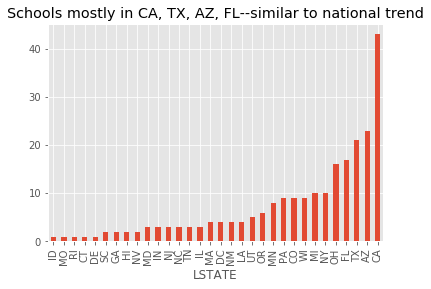

In [71]:
# here's the number of schools from each state, in a graph:
grouped_state = df.groupby('LSTATE')
grouped_state['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Schools mostly in CA, TX, AZ, FL--similar to national trend')
plt.show()

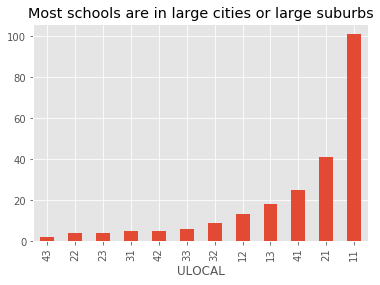

In [72]:
# and here's the number of schools in each urban category, in a graph:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Most schools are in large cities or large suburbs')
plt.show()

#### What these numbers say about the charter schools in the sample:
- Most are located in large cities, followed by large suburbs, then medium and small city, and then rural.
- The means for percent minorities and students receiving free- or reduced-price lunch are both about 60%.
- Most are in CA, TX, AZ, and FL
- Most of the schools in the sample are primary schools

#### This means that the sample reflects national averages. In that sense, this sample isn't so bad.

## Cleaning, tokenizing, and stemming the text

In [73]:
# Now we clean the webtext by rendering each word lower-case then removing punctuation. 
df['webtext_lc'] = df['WEBTEXT'].str.lower() # make the webtext lower case
df['webtokens'] = df['webtext_lc'].apply(nltk.word_tokenize) # tokenize the lower-case webtext by word
df['webtokens_nopunct'] = df['webtokens'].apply(lambda x: [word for word in x if word not in list(string.punctuation)]) # remove punctuation

In [74]:
print(df.iloc[0]["webtokens"]) # the tokenized text without punctuation

['2016', 'richland', 'two', 'career', 'pathways', 'expo', 'richland', 'school', 'district', 'two', 'will', 'be', 'hosting', 'a', 'career', 'pathways', 'expo', 'on', 'thursday', ',', 'october', '27', 'from', '3:00', 'pm', 'to', '7:00', 'pm', 'at', 'the', 'newest', 'facility', ',', 'r2i2', '(', 'behind', 'the', 'village', 'at', 'sandhill', ')', '.', 'all', 'students', 'in', 'grades', '7-12', 'along', 'with', 'their', 'parents/and', 'or', 'guardians', 'are', 'invited', 'to', 'attend', '.', 'students', 'will', 'be', 'able', 'to', 'explore', 'careers', 'and', 'educational', 'opportunities', 'in', '5', 'career', 'areas', '--', 'health', 'science', ',', 'art', ',', 'stem', ',', 'business/it', ',', 'human', 'services/education', '.', 'you', 'will', 'have', 'the', 'opportunity', 'to', 'speak', 'with', 'businesses', 'and', 'educational', 'institutions', 'to', 'see', 'the', 'connection', 'of', 'what', 'you', 'are', 'learning', 'in', 'high', 'school', 'to', 'a', 'possible', 'career', '.', 'if', 'y

In [75]:
# Now we remove stopwords and stem. This will improve the results
df['webtokens_clean'] = df['webtokens_nopunct'].apply(lambda x: [word for word in x if word not in list(stopenglish)]) # remove stopwords
df['webtokens_stemmed'] = df['webtokens_clean'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

In [76]:
# Some analyses require a string version of the webtext without punctuation or numbers.
# To get this, we join together the cleaned and stemmed tokens created above, and then remove numbers and punctuation:
df['webtext_stemmed'] = df['webtokens_stemmed'].apply(lambda x: ' '.join(char for char in x))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if char not in punctuations))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

In [77]:
df['webtext_stemmed'][0]

' richland two career pathway expo richland school district two host career pathway expo thursday octob   pm  pm newest facil ri behind villag sandhil student grade  along parentsand guardian invit attend student abl explor career educ opportun  career area  health scienc art stem businessit human serviceseduc opportun speak busi educ institut see connect learn high school possibl career question pleas contact mrs holland richland  charter high school move new locat locat anna boyd school  brookmont lane columbia sc  congratul  graduat click view video ceremoni click view thevideo june   graduat ceremoni richland two charter high school brookmontlan columbiasctel  fax   ã\x82â©copyright  richland counti school district two charter high school charter high school nutrikid district offic parent portal calendar traduccion translat ã « ââ\x88ã¬â\x97â\xad home inform school board school improv council school board school improv council calendar school counsel english leadership lab hour stu

In [78]:
# Some analyses require tokenized sentences. I'll do this with the list of dictionaries.
# I'll use cleaned, tokenized sentences (with stopwords) to create both a dictionary variable and a separate list for word2vec

words_by_sentence = [] # initialize the list of tokenized sentences as an empty list
for school in sample:
    school["sent_toksclean"] = []
    school["sent_tokens"] = [word_tokenize(sentence) for sentence in sent_tokenize(school["WEBTEXT"])] 
    for sent in school["sent_tokens"]:
        school["sent_toksclean"].append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)]) # for each word: stem, lower-case, and remove punctuations
        words_by_sentence.append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)])

In [79]:
words_by_sentence[:2]

[['2016',
  'richland',
  'two',
  'career',
  'pathway',
  'expo',
  'richland',
  'school',
  'district',
  'two',
  'will',
  'be',
  'host',
  'a',
  'career',
  'pathway',
  'expo',
  'on',
  'thursday',
  'octob',
  '27',
  'from',
  '3:00',
  'pm',
  'to',
  '7:00',
  'pm',
  'at',
  'the',
  'newest',
  'facil',
  'r2i2',
  'behind',
  'the',
  'villag',
  'at',
  'sandhil'],
 ['all',
  'student',
  'in',
  'grade',
  '7-12',
  'along',
  'with',
  'their',
  'parents/and',
  'or',
  'guardian',
  'are',
  'invit',
  'to',
  'attend']]

### Counting document lengths

In [80]:
# We can also count document lengths. I'll mostly use the version with punctuation removed but including stopwords,
# because stopwords are also part of these schools' public image/ self-presentation to potential parents, regulators, etc.

df['webstem_count'] = df['webtokens_stemmed'].apply(len) # find word count without stopwords or punctuation
df['webpunct_count'] = df['webtokens_nopunct'].apply(len) # find length with stopwords still in there (but no punctuation)
df['webclean_count'] = df['webtokens_clean'].apply(len) # find word count without stopwords or punctuation

In [81]:
# For which urban status are website self-description the longest?
print(grouped_urban['webpunct_count'].mean().sort_values(ascending=False))

ULOCAL
32    2931.111111
11    1098.594059
13     944.111111
33     921.666667
12     884.153846
41     844.000000
21     759.609756
42     747.600000
23     529.500000
43     491.500000
22     490.000000
31     363.200000
Name: webpunct_count, dtype: float64


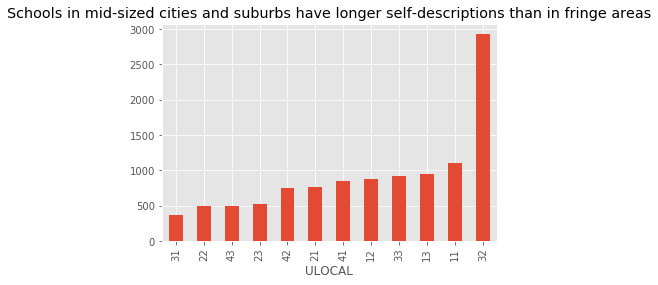

In [82]:
# here's the mean website self-description word count for schools grouped by urban proximity, in a graph:
grouped_urban['webpunct_count'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Schools in mid-sized cities and suburbs have longer self-descriptions than in fringe areas', yerr = grouped_state["webpunct_count"].std())
plt.show()

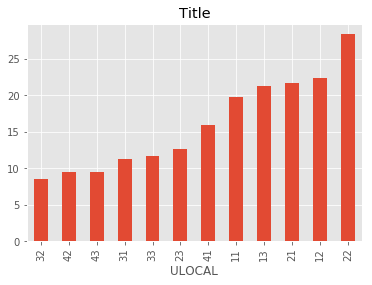

In [83]:
# Look at 'FTE' (proxy for # administrators) clustered by urban proximity and whether it explains this
grouped_urban['FTE'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Title', yerr = grouped_state["FTE"].std())
plt.show()

In [84]:
# Now let's calculate the type-token ratio (TTR) for each school, which compares
# the number of types (unique words used) with the number of words (including repetitions of words).

df['numtypes'] = df['webtokens_nopunct'].apply(lambda x: len(set(x))) # this is the number of unique words per site
df['TTR'] =  df['numtypes'] / df['webpunct_count'] # calculate TTR

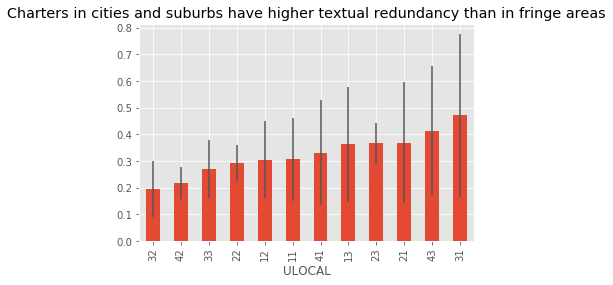

In [85]:
# here's the mean TTR for schools grouped by urban category:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['TTR'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Charters in cities and suburbs have higher textual redundancy than in fringe areas', yerr = grouped_urban["TTR"].std())
plt.show()

## (Excessively) Frequent words

In [86]:
# First, aggregate all the cleaned webtext:
webtext_all = []
df['webtokens_clean'].apply(lambda x: [webtext_all.append(word) for word in x])
webtext_all[:20]

['2016',
 'richland',
 'two',
 'career',
 'pathways',
 'expo',
 'richland',
 'school',
 'district',
 'two',
 'hosting',
 'career',
 'pathways',
 'expo',
 'thursday',
 'october',
 '27',
 '3:00',
 'pm',
 '7:00']

In [87]:
# Now apply the nltk function FreqDist to count the number of times each token occurs.
word_frequency = nltk.FreqDist(webtext_all)

#print out the 50 most frequent words using the function most_common
print(word_frequency.most_common(50))

[('school', 7186), ("''", 3979), ('elementary', 2414), ('``', 1653), ('high', 1562), ('board', 1429), ('academy', 1289), ('student', 1255), ('grade', 1227), ('us', 1136), ('students', 1099), ('calendar', 1076), ('staff', 964), ('kipp', 946), ('news', 931), ('middle', 927), ('parent', 918), ('contact', 843), ('2016', 841), ('education', 829), ('charter', 763), ('program', 735), ('schools', 723), ('information', 722), ('resources', 696), ('0', 668), ('curriculum', 643), ('college', 636), ('var', 599), ('home', 588), ('1', 582), ('learning', 571), ('nums', 568), ('community', 552), ('support', 522), ('events', 515), ('enrollment', 501), ('mission', 495), ('district', 483), ('function', 480), ('day', 463), ('handbook', 459), ('parents', 453), ('ã¢â\x80â\x93', 452), ('center', 448), ('width', 442), ("'s", 437), ('policy', 428), ('campus', 425), ('report', 421)]


 ### These are prolific, ritual, empty words and will be excluded from topic models!

## Distinctive words (mostly place names)

In [88]:
sklearn_dtm = countvec.fit_transform(df['webtext_stemmed'])
print(sklearn_dtm)

  (0, 2974)	1
  (0, 387)	1
  (0, 7082)	3
  (0, 4651)	3
  (0, 9505)	6
  (0, 590)	3
  (0, 5758)	6
  (0, 8981)	2
  (0, 7684)	2
  (0, 2408)	2
  (0, 3261)	2
  (0, 3265)	2
  (0, 6759)	2
  (0, 4644)	2
  (0, 4640)	2
  (0, 4638)	2
  (0, 2297)	2
  (0, 4164)	4
  (0, 2398)	2
  (0, 8615)	2
  (0, 6689)	2
  (0, 3264)	2
  (0, 4637)	4
  (0, 9131)	2
  (0, 4222)	4
  :	:
  (232, 8558)	4
  (232, 6684)	1
  (232, 8380)	1
  (232, 6240)	1
  (232, 1530)	3
  (232, 2778)	1
  (232, 1768)	1
  (232, 8874)	3
  (232, 1115)	3
  (232, 6974)	35
  (232, 6809)	3
  (232, 3662)	3
  (232, 387)	1
  (232, 6037)	4
  (232, 937)	3
  (232, 4089)	6
  (232, 5186)	1
  (232, 6016)	1
  (232, 5841)	1
  (232, 5862)	25
  (232, 1855)	3
  (232, 502)	5
  (232, 2670)	13
  (232, 3675)	20
  (232, 7624)	14


In [89]:
# What are some of the words in the DTM? 
print(countvec.get_feature_names()[:10])

['a', 'aa', 'aae', 'aaliyah', 'aalt', 'aapa', 'aaron', 'aasc', 'aascadmin', 'ab']


In [90]:
# now we can create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pandas.DataFrame(tfidfvec.fit_transform(df.webtext_stemmed).toarray(), columns=tfidfvec.get_feature_names(), index = df.index)

dtm_tfidf_df[:20] # let's take a look!

,aa,aae,aaliyah,aalt,aapa,aaron,aasc,aascadmin,ab,abandon,...,zuni,zupan,zweben,âgico,ân,âºblica,âºtbol,â¼tersloh,â½,ââ
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.063292
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.021738,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
11,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [91]:
# What are the 20 words with the highest TF-IDF scores?
print(dtm_tfidf_df.max().sort_values(ascending=False)[:20])

index                1.000000
offlin               0.907139
rcsa                 0.906453
sep                  0.899124
kipp                 0.896688
mater                0.885979
read                 0.885736
apma                 0.884313
uplift               0.839841
valley               0.823857
mnoh                 0.804614
amp                  0.787509
richardallenlacom    0.783290
match                0.766606
px                   0.762217
strive               0.736656
seed                 0.732476
confluenc            0.730306
mrs                  0.727873
elementari           0.727803
dtype: float64


### Like the frequent words above, these highly "unique" words are empty of meaning and will be excluded from topic models!

## Word Embeddings with word2vec

### Word2Vec features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

In [92]:
# train the model, using a minimum of 5 words
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=2, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

In [93]:
# dictionary of words in model (may not work for old gensim)
# print(len(model.vocab))
# model.vocab

In [97]:
# Find cosine distance between two given word vectors
# print(model.similarity('college-prep','align')) # these two are close to essentialism
# print(model.similarity('emot', 'curios')) # these two are close to progressivism

In [98]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                               'data-driven', 'market', 'research', 'research-bas', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'problem-solv', 'natur']

In [99]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('massachusett', 0.970444917678833), ('back-to-bas', 0.9568891525268555), ('college-preparatori', 0.9527891874313354), ('pk-12', 0.9527403712272644), ('combin', 0.9513645768165588), ('teacher/staff', 0.9481995105743408), ('overal', 0.9477005004882812), ('comprehens', 0.9460176229476929), ('hold', 0.9432240128517151), ('studentsâ\x80\x99', 0.9430220723152161)]

[('fit', 0.9366673827171326), ('bodi', 0.9327296018600464), ('standards/grad', 0.9310649037361145), ('film', 0.9286502003669739), ('theatr', 0.9261482954025269), ('justic', 0.9257835745811462), ('blend', 0.9255069494247437), ('strength', 0.9238501787185669), ('real', 0.9223808646202087), ('njh', 0.921908438205719)]


In [100]:
print(model.most_similar('emot')) # words core to progressivism

[('fit', 0.9366673827171326), ('bodi', 0.9327296018600464), ('standards/grad', 0.9310649037361145), ('film', 0.9286502003669739), ('theatr', 0.9261482954025269), ('justic', 0.9257835745811462), ('blend', 0.9255069494247437), ('strength', 0.9238501787185669), ('real', 0.9223808646202087), ('njh', 0.921908438205719)]


In [101]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
prog_words = model.most_similar(progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in progressivism:
    prog_words.append(word)
print(prog_words[:20])

KeyError: "word 'problem-solv' not in vocabulary"

In [102]:
ess_words = model.most_similar(essentialism, topn=50) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

KeyError: "word 'data-driven' not in vocabulary"

In [103]:
# construct an combined dictionary
phil_words = ess_words + prog_words

NameError: name 'ess_words' is not defined

In [44]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('emot', word) for word in phil_words]
y = [model.similarity('align', word) for word in phil_words]

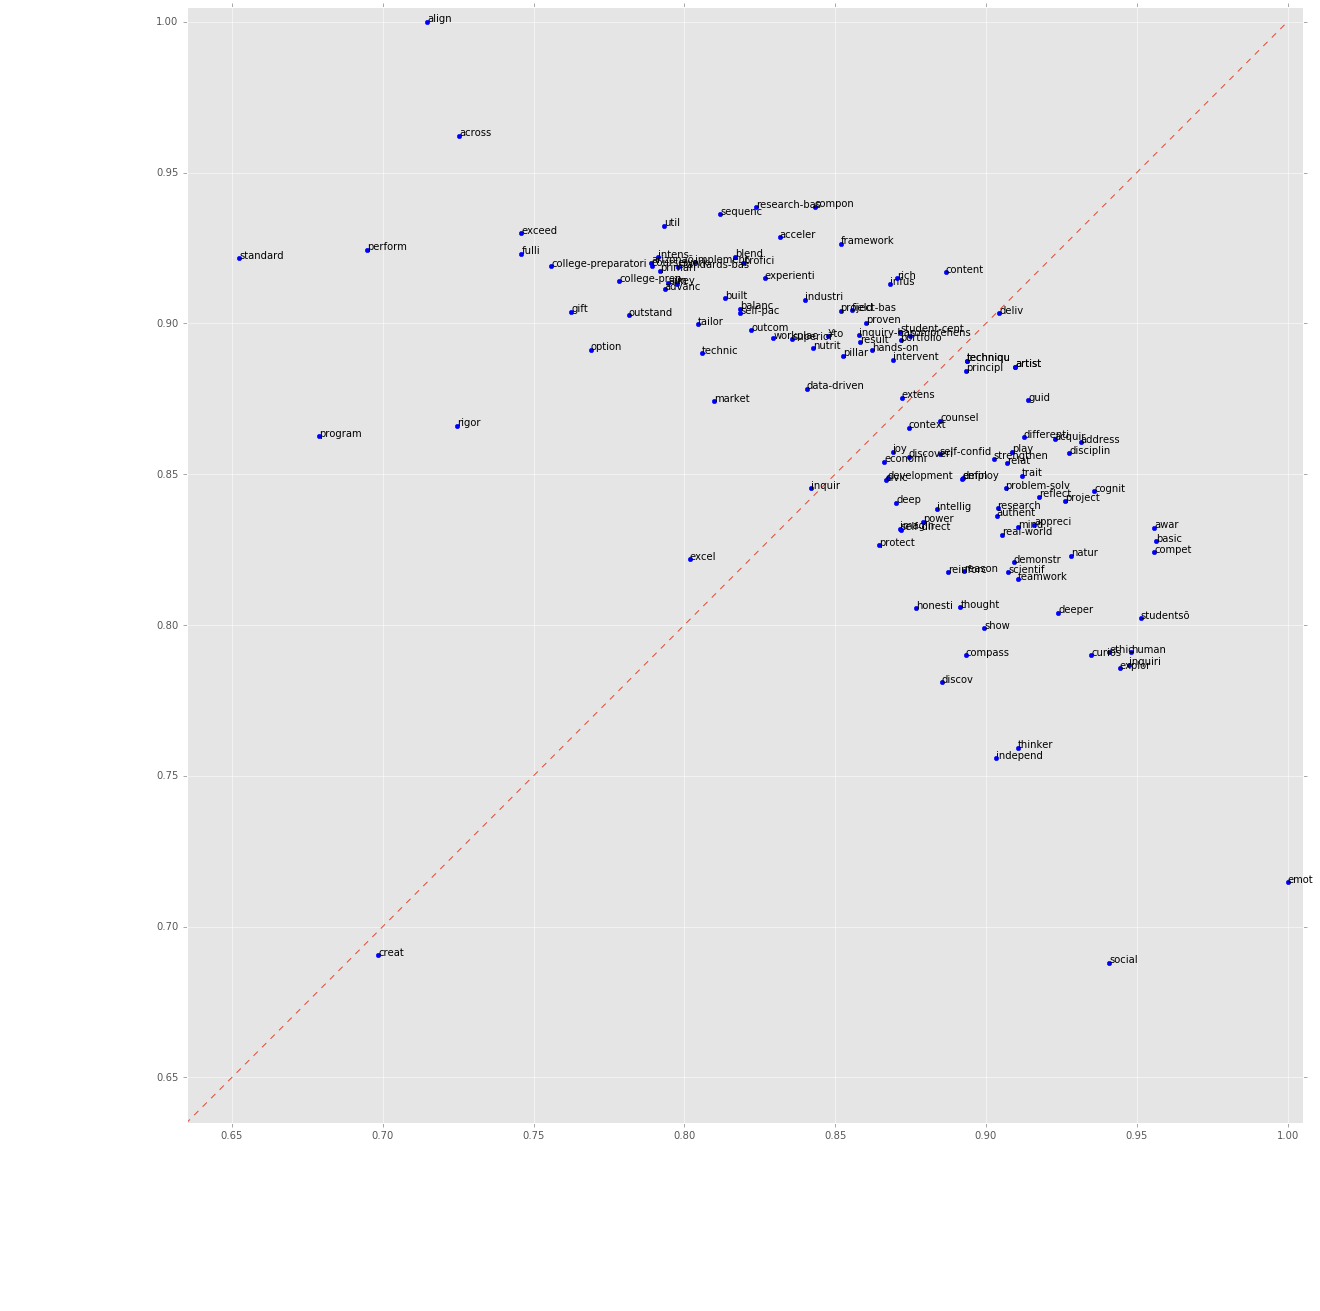

In [45]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors

## Topic Modeling with scikit-learn
> For documentation on this topic modeling (TM) package, which uses Latent Dirichlet Allocation (LDA), see [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

> And for documentation on the vectorizer package, CountVectorizer from scikit-learn, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [104]:
####Adopted From: 
#Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

# Initialize the variables needed for the topic models
n_samples = 2000
n_topics = 3
n_top_words = 50

# Create helper function that prints out the top words for each topic in a pretty way
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [105]:
# Vectorize our text using CountVectorizer
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=70, min_df=4,
                                max_features=None,
                                stop_words=stopenglish, lowercase=1
                                )

tf = tf_vectorizer.fit_transform(df.WEBTEXT)

Extracting tf features for LDA...


In [106]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

# define the lda function, with desired options
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_samples=2000 and n_topics=3...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=80.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_jobs=1, n_topics=3, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=2000, verbose=0)

In [107]:
# print the top words per topic, using the function defined above.

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
elementary 2017 2014 2015 report lunch meeting services campus policy center schedule application minutes forms september 30 special arts portal athletics ms team directory links august volunteer class view mrs form daily 00 2013 policies annual academics directors educational vision technology club 15 office leadership enroll supply es girls first

Topic #1:
life read skills courses 400 4397552 sep clubs url tech jpg family graduation enroll center ib career 2013 campus prep 300 policy talented height report english success language club width math schedule project careers leadership basis faqs special faq img texas overview partners two help connection gifted virtual directors tools

Topic #2:
kipp ed var width height position function background document left image jpg jquery speed length top true opacity right san http 100 hover margin value getelementbyid else 0px none font absolute 10px false id 10 overflow url hidden src color display direction w

These topics seem to mean:
- topic 0 relates to **GOALS**,
- topic 1 relates to **CURRICULUM**, and 
- topic 2 relates to **PHILOSOPHY** or learning process (but this topic less clear/ more mottled)

In [108]:
# Preparation for looking at distribution of topics over schools
topic_dist = lda.transform(tf) # transpose topic distribution
topic_dist_df = pandas.DataFrame(topic_dist) # turn into a df
df_w_topics = topic_dist_df.join(df) # merge with charter MS dataframe
df_w_topics[:20] # check out the merged df with topics!

,0,1,2,LEANM,SEARCH,CER_NAME,URL,ADDRESS,SCHOOL ID,LEVEL,...,webtokens,webtokens_nopunct,webtokens_clean,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR
0,0.582047,0.254995,0.162958,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",SC600,3,...,"[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathways, expo, ...","[2016, richland, two, career, pathway, expo, r...",richland two career pathway expo richland sch...,599.0,818.0,599.0,190.0,0.232274
1,0.938315,0.059893,0.001792,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",FL8131,3,...,"[back, to, polk.edu, search, the, polk, state,...","[back, to, polk.edu, search, the, polk, state,...","[back, polk.edu, search, polk, state, network,...","[back, polk.edu, search, polk, state, network,...",back polkedu search polk state network financi...,352.0,419.0,352.0,194.0,0.463007
2,0.605918,0.393238,0.000844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.997370,0.001342,0.001288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.893074,0.024390,0.082536,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",OH133389,3,...,"[lighthouse, youth, services, opened, the, lig...","[lighthouse, youth, services, opened, the, lig...","[lighthouse, youth, services, opened, lighthou...","[lighthous, youth, servic, open, lighthous, co...",lighthous youth servic open lighthous commun s...,692.0,866.0,692.0,245.0,0.282910
5,0.905148,0.092005,0.002847,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",CA124594,2,...,"[3800, del, paso, road, sacramento, ,, ca, 958...","[3800, del, paso, road, sacramento, ca, 95834,...","[3800, del, paso, road, sacramento, ca, 95834,...","[3800, del, paso, road, sacramento, ca, 95834,...",del paso road sacramento ca phone fax em...,520.0,524.0,520.0,128.0,0.244275
6,0.000235,0.999554,0.000211,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",CA6019673,1,...,"[17160, van, gogh, st., granada, hills, ,, ca,...","[17160, van, gogh, st., granada, hills, ca, 91...","[17160, van, gogh, st., granada, hills, ca, 91...","[17160, van, gogh, st., granada, hill, ca, 913...",van gogh st granada hill ca phone fax offi...,2413.0,3007.0,2413.0,672.0,0.223479
7,0.497391,0.423820,0.078789,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademies.org/schools/dayton-high/,"1407 EAST 3RD ST, DAYTON, OH",OH621,3,...,"[september, ,, 2016, sort, by, :, date, date, ...","[september, 2016, sort, by, date, date, title,...","[september, 2016, sort, date, date, title, col...","[septemb, 2016, sort, date, date, titl, color,...",septemb sort date date titl color select scho...,259.0,269.0,259.0,128.0,0.475836
8,0.994736,0.001014,0.004250,SPRING BRANCH ISD,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES ...,Westchester Academy of International Studies,https://cms.springbranchisd.com/wais/,"901 YORKCHESTER, HOUSTON, TX",TX101920014,4,...,"[901, yorkchester, houston, ,, tx, 77079, 713....","[901, yorkchester, houston, tx, 77079, 713.251...","[901, yorkchester, houston, tx, 77079, 713.251...","[901, yorkchest, houston, tx, 77079, 713.251.1...",yorkchest houston tx fax interim princip k...,3976.0,4148.0,3976.0,455.0,0.10

In [109]:
topic_columns = range(0,n_topics) # Set numerical range of topic columns for use in analyses, using n_topics from above

In [110]:
# Which schools are weighted highest for topic 0? How do they trend with regard to urban proximity and student class? 
print(df_w_topics[['LSTATE', 'ULOCAL', 'PCTETH', 'PCTFRPL', 0, 1, 2]].sort_values(by=[0], ascending=False))

    LSTATE  ULOCAL    PCTETH   PCTFRPL         0         1         2
188     MI    11.0  1.000000  0.826923  0.999840  0.000081  0.000079
225    NaN     NaN       NaN       NaN  0.999657  0.000173  0.000170
84     NaN     NaN       NaN       NaN  0.999289  0.000352  0.000359
153     TX    41.0  0.964286  0.801429  0.999244  0.000398  0.000358
185    NaN     NaN       NaN       NaN  0.999228  0.000424  0.000348
125    NaN     NaN       NaN       NaN  0.999185  0.000427  0.000388
124     CA    11.0  0.710332  0.330258  0.999144  0.000440  0.000415
57      DC    11.0  0.993750  0.981250  0.999110  0.000466  0.000424
149    NaN     NaN       NaN       NaN  0.999044  0.000515  0.000441
118     CA    11.0  0.469325  0.236196  0.999000  0.000535  0.000465
61     NaN     NaN       NaN       NaN  0.998971  0.000537  0.000492
180     OH    11.0  0.924242  0.954545  0.998900  0.000547  0.000554
95      PA    11.0  0.928113  0.609756  0.998861  0.000574  0.000565
120    NaN     NaN       NaN      

In [111]:
# Preparation for comparing total number of words aligned with each topic
# To weight each topic by its prevalenced in the corpus, multiply each topic by the word count from above

col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['webpunct_count']
    
df_w_topics[:20]

,0,1,2,LEANM,SEARCH,CER_NAME,URL,ADDRESS,SCHOOL ID,LEVEL,...,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR,0_wc,1_wc,2_wc
0,0.582047,0.254995,0.162958,RICHLAND 02,"RICHLAND TWO CHARTER HIGH 750 OLD CLEMSON RD, ...",Richland Two Charter High School,https://www.richland2.org/charterhigh/,"750 OLD CLEMSON RD, COLUMBIA, SC",SC600,3,...,"[2016, richland, two, career, pathway, expo, r...",richland two career pathway expo richland sch...,599.0,818.0,599.0,190.0,0.232274,476.114403,208.586273,133.299325
1,0.938315,0.059893,0.001792,POLK,POLK STATE COLLEGE COLLEGIATE HIGH SCHOOL 3425...,Charter High Schools | Polk State College,https://www.polk.edu/lakeland-gateway-to-colle...,"3425 WINTER LK RD LAC1200, WINTER HAVEN, FL",FL8131,3,...,"[back, polk.edu, search, polk, state, network,...",back polkedu search polk state network financi...,352.0,419.0,352.0,194.0,0.463007,393.153979,25.095026,0.750994
2,0.605918,0.393238,0.000844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.997370,0.001342,0.001288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.893074,0.024390,0.082536,LIGHTHOUSE COMMUNITY SCH INC,"LIGHTHOUSE COMMUNITY SCH INC 6100 DESMOND ST, ...",Lighthouse Community SchoolÂ¾,https://www.lys.org/services/lighthouse-commun...,"6100 DESMOND ST, CINCINNATI, OH",OH133389,3,...,"[lighthous, youth, servic, open, lighthous, co...",lighthous youth servic open lighthous commun s...,692.0,866.0,692.0,245.0,0.282910,773.401850,21.122121,71.476029
5,0.905148,0.092005,0.002847,NATOMAS UNIFIED,"WESTLAKE CHARTER MIDDLE 1985 PEBBLEWOOD DR, SA...",Westlake Charter Middle,https://westlakecharter.com,"1985 PEBBLEWOOD DR, SACRAMENTO, CA",CA124594,2,...,"[3800, del, paso, road, sacramento, ca, 95834,...",del paso road sacramento ca phone fax em...,520.0,524.0,520.0,128.0,0.244275,474.297293,48.210627,1.492080
6,0.000235,0.999554,0.000211,LOS ANGELES UNIFIED,"VAN GOGH CHARTER 17160 VAN GOGH ST, GRANADA HI...",Van Gogh Charter School,https://vangoghcs-lausd-ca.schoolloop.com/,"17160 VAN GOGH ST, GRANADA HILLS, CA",CA6019673,1,...,"[17160, van, gogh, st., granada, hill, ca, 913...",van gogh st granada hill ca phone fax offi...,2413.0,3007.0,2413.0,672.0,0.223479,0.706561,3005.660255,0.633183
7,0.497391,0.423820,0.078789,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON,SUMMIT ACADEMY TRANSITION HIGH SCHOOL DAYTON 1...,Summit Academy of Dayton,https://summitacademies.org/schools/dayton-high/,"1407 EAST 3RD ST, DAYTON, OH",OH621,3,...,"[septemb, 2016, sort, date, date, titl, color,...",septemb sort date date titl color select scho...,259.0,269.0,259.0,128.0,0.475836,133.798247,114.007603,21.194150
8,0.994736,0.001014,0.004250,SPRING BRANCH ISD,WESTCHESTER ACADEMY FOR INTERNATIONAL STUDIES ...,Westchester Academy of International Studies,https://cms.springbranchisd.com/wais/,"901 YORKCHESTER, HOUSTON, TX",TX101920014,4,...,"[901, yorkchest, houston, tx, 77079, 713.251.1...",yorkchest houston tx fax interim princip k...,3976.0,4148.0,3976.0,455.0,0.109691,4126.164616,4.206681,17.628703
9,0.789678,0.209156,0.001166,CITY ACADEMY,"CITY ACADEMY 958 JESSIE ST, SAINT PAUL, MN",City Academy,https://cityacademy.org/,"958 JESSIE ST, SAINT PAUL, MN",MN74000010,3,...,"[citi, academi, high, school, locat, east, sid...",citi academi high school locat east side st pa...,124.0,181.0,124.0,109.0,0.602210,142.931733,37.857212,0.211056


In [112]:
# Now we can see the prevalence of each topic over words for each urban category and state
grouped_urban = df_w_topics.groupby('ULOCAL')
for e in col_list:
    print(e)
    print(grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum())

grouped_state = df_w_topics.groupby('LSTATE')
for e in col_list:
    print(e)
    print(grouped_state[e].sum()/grouped_state['webpunct_count'].sum())

0_wc
ULOCAL
11.0    0.786554
12.0    0.768376
13.0    0.581481
21.0    0.793932
22.0    0.813614
23.0    0.854418
31.0    0.165619
32.0    0.864177
33.0    0.863410
41.0    0.636656
42.0    0.428913
43.0    0.121109
dtype: float64
1_wc
ULOCAL
11.0    0.117027
12.0    0.174357
13.0    0.217944
21.0    0.100293
22.0    0.178163
23.0    0.136407
31.0    0.003458
32.0    0.007551
33.0    0.135154
41.0    0.275370
42.0    0.225561
43.0    0.077913
dtype: float64
2_wc
ULOCAL
11.0    0.096419
12.0    0.057267
13.0    0.200575
21.0    0.105775
22.0    0.008223
23.0    0.009175
31.0    0.830924
32.0    0.128272
33.0    0.001436
41.0    0.087974
42.0    0.345526
43.0    0.800978
dtype: float64
0_wc
LSTATE
AZ    0.780320
CA    0.670367
CO    0.841436
DC    0.604552
DE    0.998383
FL    0.741479
GA    0.713349
HI    0.997871
ID    0.998029
IL    0.920805
IN    0.955259
LA    0.873527
MA    0.549911
MD    0.728268
MI    0.459373
MN    0.586726
MO    0.998696
NC    0.973709
NJ    0.317131
NM    0.02

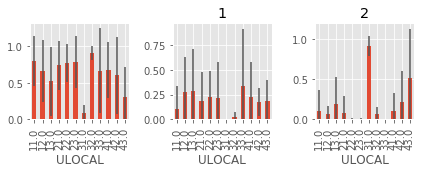

In [113]:
# Here's the distribution of urban proximity over the three topics:
fig1 = plt.figure()
chrt = 0
for num in topic_columns:
    chrt += 1 
    ax = fig1.add_subplot(2,3, chrt)
    grouped_urban[num].mean().plot(kind = 'bar', yerr = grouped_urban[num].std(), ylim=0, ax=ax, title=num)

fig1.tight_layout()
plt.show()

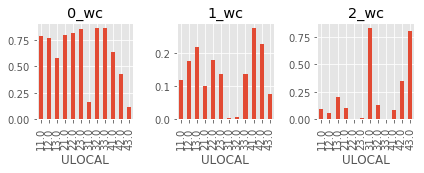

In [114]:
# Here's the distribution of each topic over words, for each urban category:
fig2 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig2.add_subplot(2,3, chrt)
    (grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum()).plot(kind = 'bar', ylim=0, ax=ax2, title=e)

fig2.tight_layout()
plt.show()